<a href="https://colab.research.google.com/github/belogabriel/churn_detect/blob/main/Data_Modelling_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando Bibliotecas

In [ ]:
%pip install imblearn
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix, ConfusionMatrixDisplay

from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier

# Data Understanding

## df_caixa

In [ ]:
df_caixa = pd.read_csv('Data/dnc_caixa.csv')
df_caixa.head()
# A coluna valor nos apresenta valores positivos e negativos, a coluna movimentações apresenta apenas
# valores positivos, ou seja, a coluna valor representa a soma de todas as entradas e saídas, podendo
# fechar o dia no negativo ou positivo. Já a coluna movimentações representa a quantidade de entradas
# e saídas

,salao_id,status,datacad_mes,valor,movimentacoes
0,62259,1,2022-03-01,-659.45,25
1,23822,1,2019-05-01,-15358.44,121
2,51335,1,2020-01-01,-3076.84,32
3,37555,1,2020-02-01,-532.00,21
4,62312,1,2020-02-01,-11347.02,146


In [ ]:
df_caixa.info()
#Apenas um dado faltante na coluna valor

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231299 entries, 0 to 231298
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   salao_id       231299 non-null  int64  
 1   status         231299 non-null  int64  
 2   datacad_mes    231299 non-null  object 
 3   valor          231298 non-null  float64
 4   movimentacoes  231299 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 8.8+ MB


In [ ]:
df_caixa.describe()

,salao_id,status,valor,movimentacoes
count,231299.000000,231299.000000,2.312980e+05,231299.000000
mean,52620.707439,0.638762,2.339182e+03,24.886558
std,20197.973647,0.480360,2.081368e+06,41.562228
min,100.000000,0.000000,-8.211342e+05,1.000000
25%,36123.000000,0.000000,-2.338100e+03,2.000000
50%,58884.000000,1.000000,-5.088900e+02,9.000000
75%,66506.000000,1.000000,-7.200000e+01,30.000000
max,87912.000000,1.000000,9.999988e+08,3319.000000


In [ ]:
df_caixa.duplicated().sum()
#Nenhum dado duplicado

0

In [ ]:
df_caixa.status.unique()

# Entende-se que status só pode representar 2 valores, sendo 0 (Aberto) ou 1 (Fechado)

array([1, 0])

## df_saloes


In [ ]:
df_saloes = pd.read_csv('Data/dnc_saloes.csv')
df_saloes.head()
#Datacad é a data de cadastro do salão e data_expiracao é a data que expira o cadastro

,id,datacad,pagamento_online,revenda_id,nfc_e,nfs_e,avecpay_id,limite_profissionais,data_expiracao,cidade
0,31092,2018-06-27 20:41:25.000000,0,0.0,0,0,0,10,2023-08-21,Guarulhos
1,31140,2018-06-28 15:15:31.000000,0,57.0,0,0,0,5,2018-07-03,Macaé
2,31202,2018-06-29 16:16:33.000000,0,0.0,0,0,0,10,2023-08-03,João Pessoa
3,31365,2018-07-03 15:59:38.000000,0,0.0,0,0,0,20,2020-09-24,Rio de Janeiro
4,31390,2018-07-03 23:21:42.000000,0,NaN,0,0,0,5,2023-01-12,Taubaté


In [ ]:
df_saloes.info()
# verifica-se falta de dados nas colunas data_expiracao, cidade e revenda_id

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30500 entries, 0 to 30499
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    30500 non-null  int64  
 1   datacad               30500 non-null  object 
 2   pagamento_online      30500 non-null  int64  
 3   revenda_id            29548 non-null  float64
 4   nfc_e                 30500 non-null  int64  
 5   nfs_e                 30500 non-null  int64  
 6   avecpay_id            30500 non-null  int64  
 7   limite_profissionais  30500 non-null  int64  
 8   data_expiracao        30487 non-null  object 
 9   cidade                27259 non-null  object 
dtypes: float64(1), int64(6), object(3)
memory usage: 2.3+ MB


In [ ]:
df_saloes.describe()

,id,pagamento_online,revenda_id,nfc_e,nfs_e,avecpay_id,limite_profissionais
count,30500.000000,30500.000000,29548.000000,30500.000000,30500.000000,30500.000000,30500.000000
mean,64567.806590,0.080918,16.081596,0.036918,0.065246,10826.885180,221.715836
std,19570.198466,0.272714,54.934635,0.188564,0.246963,14808.096943,1410.283948
min,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,58108.750000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
50%,69652.500000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
75%,78643.250000,0.000000,0.000000,0.000000,0.000000,24081.250000,10.000000
max,87725.000000,1.000000,288.000000,1.000000,1.000000,42584.000000,17992.000000


In [ ]:
df_saloes.duplicated().sum()

# Nenhum dado duplicado

0

In [ ]:
df_saloes.pagamento_online.unique()
# A coluna pagamento_online representa se o salão aceita ou não pagamento online

array([0, 1])

In [ ]:
df_saloes.revenda_id.unique()
# Essa coluna representa o id de revenda

array([  0.,  57.,  nan, 281.,   3.,  32.,  21.,  40.,  33.,   6.,   7.,
        76.,   2.,  59.,  36.,  14.,  55.,   4.,  77.,  78.,  73.,  15.,
        45.,  17.,   9., 260., 261.,  38.,  11.,  34., 287., 277., 273.,
       271., 274.,  74.,  71., 286.,  51.,  64.,  65.,  43.,  37., 265.,
        46., 262., 269.,  23.,  29., 288.,  62.,  48.,  72.,  81.,  25.,
        44.,  47., 266.,  58.])

In [ ]:
df_saloes.nfc_e.unique()
# essa coluna representa se o salão utiliza emissão de nota fiscal de consumidor eletrônica

array([0, 1])

In [ ]:
df_saloes.nfs_e.unique()
# essa coluna representa se o salão utiliza emissão de nota fiscal de serviços eletrônica

array([0, 1])

In [ ]:
df_saloes.avecpay_id.unique()
# Representa o id dos salões que usam avecpay

array([    0, 39867,  3152, ...,  9243,  9396, 10750])

## df_comandas


In [ ]:
df_comandas = pd.read_csv('Data/dnc_comandas.csv')
df_comandas.head()

#mes_data é a data daquela comanda, importando apenas o mês e o ano. Valor representa o valor da comanda e comandas representa o número da comanda.

,salao_id,mes_data,status,comandas,valor
0,57604,2020-10-01,0,4,158.0
1,21634,2019-06-01,0,2,45.0
2,55313,2022-07-01,0,4,840.0
3,69356,2021-01-01,2,16,2300.0
4,85368,2022-08-01,1,1,150.0


In [ ]:
df_comandas.status.unique()

# Status são números que representam o status da comanda, não será utilizado.

array([ 0,  2,  1,  3, -1])

In [ ]:
df_comandas.info()
# Nenhum dado faltante

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599757 entries, 0 to 599756
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   salao_id  599757 non-null  int64 
 1   mes_data  599757 non-null  object
 2   status    599757 non-null  int64 
 3   comandas  599757 non-null  int64 
 4   valor     599757 non-null  object
dtypes: int64(3), object(2)
memory usage: 22.9+ MB


In [ ]:
df_comandas.describe()

,salao_id,status,comandas
count,599757.000000,599757.000000,599757.000000
mean,56879.529493,1.153731,182.244317
std,20482.311961,0.982677,333.558933
min,8.000000,-1.000000,1.000000
25%,47564.000000,0.000000,4.000000
50%,62254.000000,2.000000,32.000000
75%,71785.000000,2.000000,233.000000
max,87926.000000,3.000000,8989.000000


In [ ]:
df_comandas.duplicated().sum()
# Nenhum dado duplicado

0

## df_hist_churn

In [ ]:
df_hist_churn = pd.read_csv('Data/dnc_hist_churn.csv')
df_hist_churn


,id,datacad,tier,data_verificacao,status_churn
0,80574,2021-12-15,2.SMALL,2022-04-30,ATIVO
1,80575,2021-12-15,1.MICRO,2022-04-30,CHURN
2,80576,2021-12-16,2.SMALL,2022-04-30,CHURN
3,80577,2021-12-16,3.MEDIUM,2022-04-30,INATIVO
4,80578,2021-12-16,1.MICRO,2022-04-30,CHURN
...,...,...,...,...,...
537979,69651,2020-11-24,2.SMALL,2021-12-31,ATIVO
537980,69652,2020-11-24,5.ENTERPRISE,2021-12-31,ATIVO
537981,69653,2020-11-24,3.MEDIUM,2021-12-31,ATIVO
537982,69654,2020-11-24,3.MEDIUM,2021-12-31,ATIVO


In [ ]:
""" data cad é a data de cadastro do salão, tier é a classificação desse salão de
  acordo com a quantidade de funcionários e data_verificacao é a data que foi feita
  essa verificação """

' data cad é a data de cadastro do salão, tier é a classificação desse salão de \n  acordo com a quantidade de funcionários e data_verificacao é a data que foi feita\n  essa verificação '

In [ ]:
df_hist_churn.status_churn.unique()
# Representa o status do cliente, podendo ser ativo, churn, inativo ou inadimplente

array(['ATIVO', 'CHURN', 'INATIVO', 'INADIMPLENTE'], dtype=object)

In [ ]:
df_hist_churn.info()
# Nenhum dado faltante

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537984 entries, 0 to 537983
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                537984 non-null  int64 
 1   datacad           537984 non-null  object
 2   tier              537984 non-null  object
 3   data_verificacao  537984 non-null  object
 4   status_churn      537984 non-null  object
dtypes: int64(1), object(4)
memory usage: 20.5+ MB


In [ ]:
df_hist_churn.duplicated().sum()
# Nenhum dado duplicado

0

In [ ]:
df_hist_churn.describe()

,id
count,537984.000000
mean,57221.600799
std,20066.026361
min,23.000000
25%,48843.000000
50%,62736.000000
75%,71636.000000
max,87725.000000


# Data Preparation


In [ ]:
def not_cient_para_num(df_com_coluna):
  '''Essa função foi feita para transformar dados que foram escritos em notação científica para números reais
      df_com_coluna: informe o dataframe especificando a coluna que precisará da alteração
      Obs.: Apenas funciona com o tipo de dado object
  '''
  for i in range(0, len(df_com_coluna)):
    if len(df_com_coluna[i]) > 4:
      if df_com_coluna[i][4] == 'E':
        df_com_coluna[i] = float(df_com_coluna.loc[i][0]) * (10 ** float(df_com_coluna.loc[i][6:8]))
      else:
        continue
    else:
      continue

In [ ]:
df_comandas['valor'] = (df_comandas['valor'].str.replace('.', ''))
not_cient_para_num(df_comandas.valor)
df_comandas.valor = df_comandas.valor.astype('float64')

/tmp/ipykernel_5924/21807263.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_comandas['valor'] = (df_comandas['valor'].str.replace('.', ''))
/tmp/ipykernel_5924/1419751444.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_com_coluna[i] = float(df_com_coluna.loc[i][0]) * (10 ** float(df_com_coluna.loc[i][6:8]))


In [ ]:
df_comandas_total = df_comandas.groupby(['salao_id']).sum().drop(columns=['status', 'comandas']).reset_index()
#df_comandas_total.head()

/tmp/ipykernel_5924/1494314547.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_comandas_total = df_comandas.groupby(['salao_id']).sum().drop(columns=['status', 'comandas']).reset_index()


In [ ]:
df_hist_churn['datacad'] = pd.to_datetime(df_hist_churn['datacad'])
df_saloes['datacad'] = pd.to_datetime(df_saloes['datacad'])
#alteramos o tipo para datetime da coluna datacad do df_hist_churn e do df_saloes para fazer um merge
df_saloes['datacad'] = df_saloes['datacad'].dt.date
df_saloes['datacad'] = pd.to_datetime(df_saloes['datacad'])
#modelamos a coluna datacad do df_saloes para apresentar apenas dia, mês e ano sem perder o tipo datetime

In [ ]:
df_hist_churn_saloes = df_hist_churn.merge(df_saloes, how='left', on=['id','datacad'])
#df_hist_churn_saloes.head()
#Realizamos o merge com as colunas id e datacad sendo a nossa chave primária

In [ ]:
df_hist_churn_saloes.isna().sum()
# Grande presença de dados nulos

id                          0
datacad                     0
tier                        0
data_verificacao            0
status_churn                0
pagamento_online         4066
revenda_id              18088
nfc_e                    4066
nfs_e                    4066
avecpay_id               4066
limite_profissionais     4066
data_expiracao           4157
cidade                  36686
dtype: int64

In [ ]:
df_hist_churn_saloes = df_hist_churn_saloes.dropna()
#df_hist_churn_saloes.isna().sum()
#Eliminação dos dados nulos

In [ ]:
df_hist_churn.duplicated().sum()
#Nenhum dado duplicado

0

In [ ]:
df_hist_churn_saloes.rename(columns={'id': 'salao_id'}, inplace=True)
#Renomeando a coluna id para futuras manipulações

In [ ]:
df_hist_churn_saloes['data_verificacao'] = pd.to_datetime(df_hist_churn_saloes['data_verificacao'])
#Alterando a coluna data_verificacao para datetime

In [ ]:
df_hist_churn_saloes.reset_index(inplace=True, drop=True)

In [ ]:
#df_hist_churn_saloes.head()

In [ ]:
df_model = df_hist_churn_saloes.merge(df_comandas_total, how='left', on=['salao_id'])
# Fazendo um merge utilizando a chave primária salao_id

In [ ]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 491145 entries, 0 to 491144
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   salao_id              491145 non-null  int64         
 1   datacad               491145 non-null  datetime64[ns]
 2   tier                  491145 non-null  object        
 3   data_verificacao      491145 non-null  datetime64[ns]
 4   status_churn          491145 non-null  object        
 5   pagamento_online      491145 non-null  float64       
 6   revenda_id            491145 non-null  float64       
 7   nfc_e                 491145 non-null  float64       
 8   nfs_e                 491145 non-null  float64       
 9   avecpay_id            491145 non-null  float64       
 10  limite_profissionais  491145 non-null  float64       
 11  data_expiracao        491145 non-null  object        
 12  cidade                491145 non-null  object        
 13 

In [ ]:
df_model.describe()

,salao_id,pagamento_online,revenda_id,nfc_e,nfs_e,avecpay_id,limite_profissionais,valor
count,491145.000000,491145.000000,491145.000000,491145.000000,491145.000000,491145.000000,491145.000000,4.358200e+05
mean,57106.798066,0.113791,19.353291,0.055334,0.099207,9027.359902,305.693679,5.098478e+13
std,20085.225285,0.317558,59.419323,0.228631,0.298940,12674.703249,1639.130710,2.873311e+15
min,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,48951.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,5.569300e+05
50%,62758.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,8.436633e+06
75%,71440.000000,0.000000,3.000000,0.000000,0.000000,19245.000000,10.000000,4.724912e+07
max,87725.000000,1.000000,288.000000,1.000000,1.000000,42584.000000,17992.000000,2.300011e+17


In [ ]:
df_model.isna().sum()
#Alguns dados nulos na coluna valor

salao_id                    0
datacad                     0
tier                        0
data_verificacao            0
status_churn                0
pagamento_online            0
revenda_id                  0
nfc_e                       0
nfs_e                       0
avecpay_id                  0
limite_profissionais        0
data_expiracao              0
cidade                      0
valor                   55325
dtype: int64

In [ ]:
perc_5 = np.nanpercentile(df_model.valor, 50)

In [ ]:
df_model.fillna(value=perc_5, inplace=True)

In [ ]:
df_model.duplicated().sum()
# Nenhum dado duplicado

0

In [ ]:
df_model = pd.get_dummies(data=df_model, columns=['tier'], prefix=['tier'])
# Realizando a dummyficação na coluna tier

In [ ]:
#df_model.head()

In [ ]:
df_model['status_churn'] = df_model['status_churn'].replace({'ATIVO': 0, 'CHURN': 1, 'INATIVO': 1, 'INADIMPLENTE': 1})
# Status churn será o nosso target para o modelo, por isso devemos alterar os valores para numéricos

In [ ]:
df_model['pagamento_online'] = df_model['pagamento_online'].astype('int64')
df_model['revenda_id'] = df_model['revenda_id'].astype('int64')
df_model['nfc_e'] = df_model['nfc_e'].astype('int64')
df_model['nfs_e'] = df_model['nfs_e'].astype('int64')
df_model['avecpay_id'] = df_model['avecpay_id'].astype('int64')
df_model['limite_profissionais'] = df_model['limite_profissionais'].astype('int64')
# Alterando o tipo das colunas

In [ ]:
df_model.reset_index(inplace=True, drop=True)

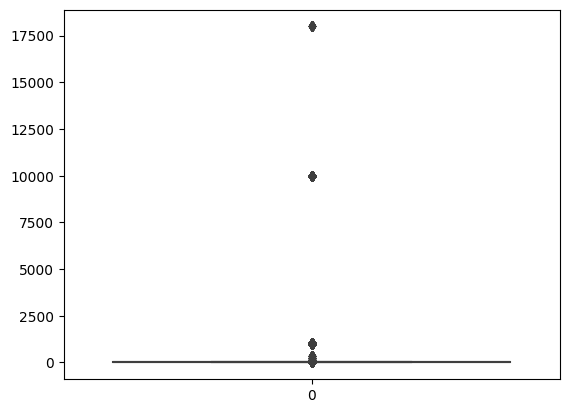

In [ ]:
sns.boxplot(df_model.limite_profissionais);
# Verificando presença de outliers

In [ ]:
q1_lp = np.percentile(df_model['limite_profissionais'], 25,
                   interpolation = 'midpoint')

q3_lp = np.percentile(df_model['limite_profissionais'], 75,
                   interpolation = 'midpoint')
iqr_lp = q3_lp - q1_lp

print("Old Shape: ", df_model.shape)

# Limite Superior
upper_lp = np.where(df_model['limite_profissionais'] >= (q3_lp+1.5*iqr_lp))
# Limite Inferior
lower_lp = np.where(df_model['limite_profissionais'] <= (q1_lp-1.5*iqr_lp))

# Removendo Outliers
df_model.drop(upper_lp[0], inplace = True)
df_model.drop(lower_lp[0], inplace = True)

print("New Shape: ", df_model.shape)

Old Shape:  (491145, 18)
New Shape:  (374115, 18)


/tmp/ipykernel_5924/1810573259.py:1: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  q1_lp = np.percentile(df_model['limite_profissionais'], 25,
/tmp/ipykernel_5924/1810573259.py:4: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  q3_lp = np.percentile(df_model['limite_profissionais'], 75,


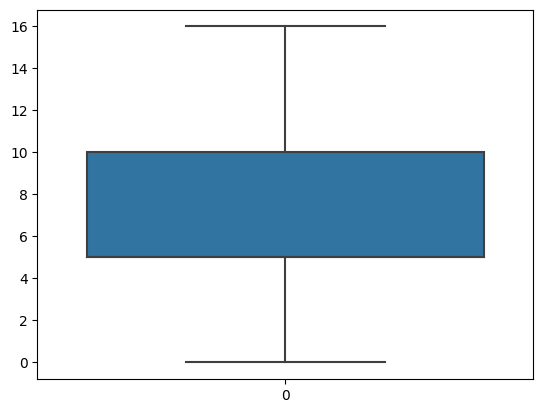

In [ ]:
sns.boxplot(df_model.limite_profissionais);
# Verificando novamente...

In [ ]:
df_model.reset_index(inplace=True, drop=True)

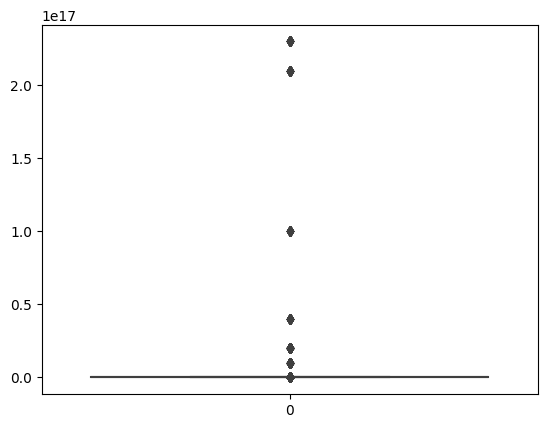

In [ ]:
sns.boxplot(df_model.valor);
# Verificando presença de outliers

In [ ]:
q1_v = np.percentile(df_model['valor'], 25,
                   interpolation = 'midpoint')

q3_v = np.percentile(df_model['valor'], 75,
                   interpolation = 'midpoint')
iqr_v = q3_v - q1_v

print("Old Shape: ", df_model.shape)

# Limite Superior
upper_v = np.where(df_model['valor'] >= (q3_v+1.5*iqr_v))
# Limite Inferior
lower_v = np.where(df_model['valor'] <= (q1_v-1.5*iqr_v))

# Removendo Outliers
df_model.drop(upper_v[0], inplace = True)
df_model.drop(lower_v[0], inplace = True)

print("New Shape: ", df_model.shape)

Old Shape:  (374115, 18)
New Shape:  (323971, 18)


/tmp/ipykernel_5924/2472746955.py:1: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  q1_v = np.percentile(df_model['valor'], 25,
/tmp/ipykernel_5924/2472746955.py:4: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  q3_v = np.percentile(df_model['valor'], 75,


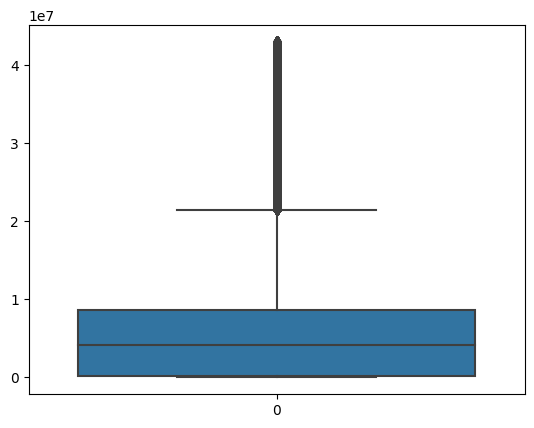

In [ ]:
sns.boxplot(df_model.valor);
# Verificando novamente...

In [ ]:
df_model.reset_index(inplace=True, drop=True)

In [ ]:
df_model[df_model['revenda_id'] != 0] = 1
df_model[df_model['avecpay_id'] != 0] = 1
#Alterando os valores diferentes de 0 para 1, alterando, assim, as colunas revenda_id e avexpay_id para binárias

In [ ]:
df_model['dias_cad_verif'] = abs(df_model['datacad'] - df_model['data_verificacao'])
df_model['dias_cad_verif'] = pd.to_timedelta(df_model['dias_cad_verif'], unit='D')
df_model['dias_cad_verif'] = df_model['dias_cad_verif'] / np.timedelta64(1, 'D')
df_model['dias_cad_verif'] = df_model['dias_cad_verif'].astype('int64')
# Criando a coluna dias_cad_verif, que a diferença de dias entre o cadastro e a verificação do status

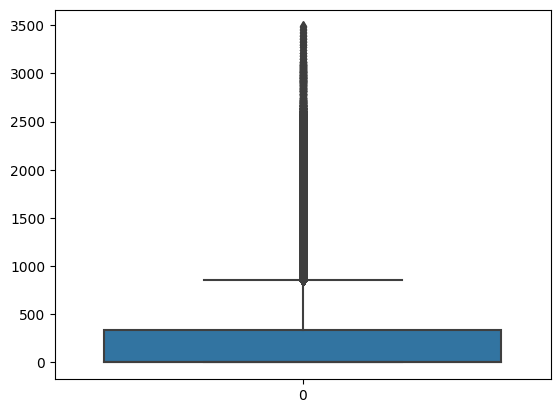

In [ ]:
sns.boxplot(df_model.dias_cad_verif);
#Verificando outliers...

In [ ]:
q1_d = np.percentile(df_model['dias_cad_verif'], 25,
                   interpolation = 'midpoint')

q3_d = np.percentile(df_model['dias_cad_verif'], 75,
                   interpolation = 'midpoint')
iqr_d = q3_d - q1_d

print("Old Shape: ", df_model.shape)

# Limite Superior
upper_d = np.where(df_model['dias_cad_verif'] >= (q3_d+1.5*iqr_d))
# Limite Inferior
lower_d = np.where(df_model['dias_cad_verif'] <= (q1_d-1.5*iqr_d))

# Removendo Outliers
df_model.drop(upper_d[0], inplace = True)
df_model.drop(lower_d[0], inplace = True)

print("New Shape: ", df_model.shape)

Old Shape:  (323971, 19)
New Shape:  (286503, 19)


/tmp/ipykernel_5924/38908033.py:1: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  q1_d = np.percentile(df_model['dias_cad_verif'], 25,
/tmp/ipykernel_5924/38908033.py:4: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  q3_d = np.percentile(df_model['dias_cad_verif'], 75,


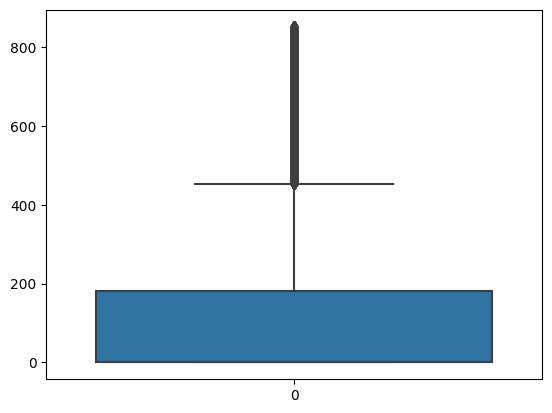

In [ ]:
sns.boxplot(df_model.dias_cad_verif);
# Verificando novamente...

In [ ]:
df_model.reset_index(inplace=True, drop=True)

In [ ]:
df_model.shape

(286503, 19)

In [ ]:
df_model.duplicated().sum()

176778

In [ ]:
df_model.drop_duplicates(inplace=True)

In [ ]:
df_model.shape

(109725, 19)

In [ ]:
df_model.reset_index(inplace=True, drop=True)

# Modelling

### Separação das features


In [ ]:
df_model.rename(columns={'tier_1.MICRO': 'tier_1_MICRO',
                         'tier_2.SMALL': 'tier_2_SMALL',
                         'tier_3.MEDIUM': 'tier_3_MEDIUM',
                         'tier_4.LARGE': 'tier_4_LARGE',
                         'tier_5.ENTERPRISE': 'tier_5_ENTERPRISE'
                        }, inplace=True)

In [ ]:
x_features = ['pagamento_online','avecpay_id','valor','limite_profissionais','tier_1_MICRO',
              'tier_2_SMALL','tier_3_MEDIUM','tier_4_LARGE','tier_5_ENTERPRISE', 'dias_cad_verif']
x = df_model[x_features]
y = df_model['status_churn']

In [ ]:
# Padronização dos dados
scaler = StandardScaler()
x_std = x.copy()
x_std[['valor','limite_profissionais','dias_cad_verif']] = scaler.fit_transform(x[['valor','limite_profissionais','dias_cad_verif']])

In [ ]:
# Separação em treino e teste
x_train, x_test, y_train, y_test = train_test_split(x_std, y, test_size=0.3, random_state=42)

In [ ]:
# Realizando o balanceamento dos dados
smt = SMOTE(random_state=42)
x_res, y_res = smt.fit_resample(x_train, y_train)

### Decision Tree Classifier (Modelo Escolhido)

In [ ]:
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(x_res, y_res)

DecisionTreeClassifier(random_state=42)

#### Avaliação do Modelo DTC

In [ ]:
dtc_pred = dtc.predict(x_test)

In [ ]:
dtc_pred = pd.DataFrame(dtc_pred, columns=['status_churn'])
dtc_pred.value_counts()

status_churn
0               23255
1                9663
dtype: int64

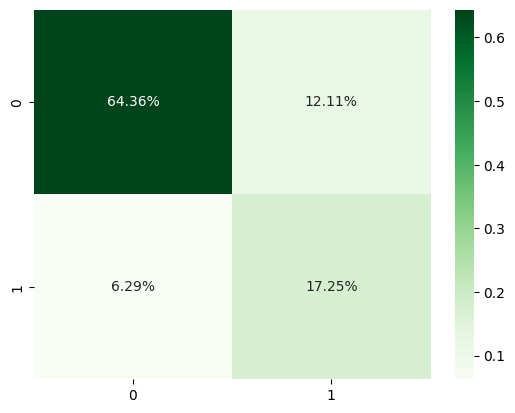

In [ ]:
cm = confusion_matrix(y_test, dtc_pred, labels=dtc.classes_)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
# disp.plot()
# plt.show()
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Greens')
plt.show()

In [ ]:
print(f"Acurácia DTC (Treino): {accuracy_score(y_train, dtc.predict(x_train))}")
print(f"Acurácia DTC (Teste): {accuracy_score(y_test, dtc.predict(x_test))}")
print("====================================")
print(f"Precision DTC (Treino): {precision_score(y_train, dtc.predict(x_train), average='macro')}")
print(f"Precision DTC (Teste): {precision_score(y_test, dtc.predict(x_test), average='macro')}")
print("====================================")
print(f"Recall DTC (Treino): {recall_score(y_train, dtc.predict(x_train), average='macro')}")
print(f"Recall DTC (Teste): {recall_score(y_test, dtc.predict(x_test), average='macro')}")
print("====================================")
print(f"F1-Score DTC (Treino): {f1_score(y_train, dtc.predict(x_train), average='macro')}")
print(f"F1-Score DTC (Teste): {f1_score(y_test, dtc.predict(x_test), average='macro')}")

Acurácia DTC (Treino): 0.9605114117202859
Acurácia DTC (Teste): 0.816058083723191
Precision DTC (Treino): 0.9381795685429162
Precision DTC (Teste): 0.7492945392382948
Recall DTC (Treino): 0.9552728961024881
Recall DTC (Teste): 0.7872554394700446
F1-Score DTC (Treino): 0.946321795773834
F1-Score DTC (Teste): 0.7635963141643998


In [ ]:
features_importance = zip(dtc.feature_importances_, x_features)
for importance, feature in sorted(features_importance, reverse=True):
    print("%s: %f%%" % (feature, importance*100))

valor: 60.720479%
dias_cad_verif: 35.443769%
limite_profissionais: 2.236493%
tier_2_SMALL: 0.686166%
tier_1_MICRO: 0.433861%
tier_3_MEDIUM: 0.360927%
pagamento_online: 0.085118%
tier_4_LARGE: 0.033187%
tier_5_ENTERPRISE: 0.000000%
avecpay_id: 0.000000%


### Random Forest Classifier

In [ ]:
rf = RandomForestClassifier(random_state=42)
rf.fit(x_res, y_res)

RandomForestClassifier(random_state=42)

#### Avaliação do Modelo RF

In [ ]:
rf_pred = pd.DataFrame(rf.predict(x_test), columns=['status_churn'])
rf_pred.status_churn.unique()

array([0, 1])

In [ ]:
rf_pred.status_churn.value_counts()

0    23048
1     9870
Name: status_churn, dtype: int64

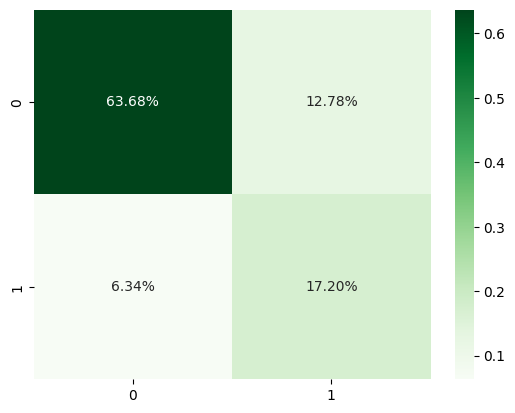

In [ ]:
cm = confusion_matrix(y_test, rf_pred, labels=rf.classes_)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
# disp.plot()
# plt.show()
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Greens')
plt.show()

In [ ]:
print(f"Acurácia rf (Treino): {accuracy_score(y_train, rf.predict(x_train))}")
print(f"Acurácia rf (Teste): {accuracy_score(y_test, rf.predict(x_test))}")
print("====================================")
print(f"Precision rf (Treino): {precision_score(y_train, rf.predict(x_train), average='macro')}")
print(f"Precision rf (Teste): {precision_score(y_test, rf.predict(x_test), average='macro')}")
print("====================================")
print(f"Recall rf (Treino): {recall_score(y_train, rf.predict(x_train), average='macro')}")
print(f"Recall rf (Teste): {recall_score(y_test, rf.predict(x_test), average='macro')}")
print("====================================")
print(f"F1-Score rf (Treino): {f1_score(y_train, rf.predict(x_train), average='macro')}")
print(f"F1-Score rf (Teste): {f1_score(y_test, rf.predict(x_test), average='macro')}")

Acurácia rf (Treino): 0.9601468616141758
Acurácia rf (Teste): 0.8087976183243211
Precision rf (Treino): 0.9338928473097821
Precision rf (Teste): 0.7415753898212338
Recall rf (Treino): 0.9611691540643019
Recall rf (Teste): 0.7817930381100822
F1-Score rf (Treino): 0.9464752651443198
F1-Score rf (Teste): 0.7561097823865661


In [ ]:

features_importance = zip(rf.feature_importances_, x_features)
for importance, feature in sorted(features_importance, reverse=True):
    print("%s: %f%%" % (feature, importance*100))

valor: 53.993619%
dias_cad_verif: 38.320980%
limite_profissionais: 3.949116%
tier_1_MICRO: 1.944177%
tier_3_MEDIUM: 1.094280%
tier_2_SMALL: 0.498919%
pagamento_online: 0.100036%
tier_4_LARGE: 0.097549%
tier_5_ENTERPRISE: 0.000991%
avecpay_id: 0.000333%


#### Optimization and Saving Model

In [ ]:
# parameters = {
#     "criterion": ['gini', 'entropy', 'log_loss'],
#     "n_estimators": [50, 75, 100],
#     "bootstrap": [False, True],
#     "max_depth": [3, 5, 10, None],
#     "max_features": ['sqrt', 'log2', None]
# }

# grid_search = GridSearchCV(rf, parameters, scoring='f1_macro', n_jobs=-1)
# grid_search.fit(x_res, y_res)

GridSearchCV(estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [False, True],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [3, 5, 10, None],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [50, 75, 100]},
             scoring='f1_macro')

In [ ]:
# print(" Results from Grid Search " )
# print("\n The best estimator across ALL searched params:\n",grid_search.best_estimator_)
# print("\n The best score across ALL searched params:\n",grid_search.best_score_)
# print("\n The best parameters across ALL searched params:\n",grid_search.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 RandomForestClassifier(criterion='entropy', max_features=None, random_state=42)

 The best score across ALL searched params:
 0.851649890825653

 The best parameters across ALL searched params:
 {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'n_estimators': 100}


In [ ]:
rf_tunned = RandomForestClassifier(random_state=42,
                                    bootstrap=True,
                                    criterion='entropy',
                                    max_depth=None,
                                    max_features=None,
                                    n_estimators=100)
rf_tunned.fit(x_res, y_res)

RandomForestClassifier(criterion='entropy', max_features=None, random_state=42)

In [ ]:
print(f"Acurácia rf_tunned (Treino): {accuracy_score(y_train, rf_tunned.predict(x_train))}")
print(f"Acurácia rf_tunned (Teste): {accuracy_score(y_test, rf_tunned.predict(x_test))}")
print("====================================")
print(f"Precision rf_tunned (Treino): {precision_score(y_train, rf_tunned.predict(x_train), average='macro')}")
print(f"Precision rf_tunned (Teste): {precision_score(y_test, rf_tunned.predict(x_test), average='macro')}")
print("====================================")
print(f"Recall rf_tunned (Treino): {recall_score(y_train, rf_tunned.predict(x_train), average='macro')}")
print(f"Recall rf_tunned (Teste): {recall_score(y_test, rf_tunned.predict(x_test), average='macro')}")
print("====================================")
print(f"F1-Score rf_tunned (Treino): {f1_score(y_train, rf_tunned.predict(x_train), average='macro')}")
print(f"F1-Score rf_tunned (Teste): {f1_score(y_test, rf_tunned.predict(x_test), average='macro')}")

Acurácia rf_tunned (Treino): 0.9602770580806437
Acurácia rf_tunned (Teste): 0.835561091196306
Precision rf_tunned (Treino): 0.9344668610223001
Precision rf_tunned (Teste): 0.7721798163028639
Recall rf_tunned (Treino): 0.9606256423356103
Recall rf_tunned (Teste): 0.8090316257297563
F1-Score rf_tunned (Treino): 0.9465782947810915
F1-Score rf_tunned (Teste): 0.7867807462348533


In [ ]:
import pickle

with open('churn_model.pkl', 'wb') as file:
  pickle.dump(rf, file)

In [ ]:
with open('churn_model_tunned.pkl', 'wb') as file:
  pickle.dump(rf_tunned, file)

### XGBClassifier

In [ ]:
xgb = XGBClassifier(random_state=42)
xgb.fit(x_res, y_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

#### Avaliação do Modelo XGBC

In [ ]:
xgb_pred = pd.DataFrame(xgb.predict(x_test), columns=['status_churn'])
xgb_pred.status_churn.unique()

array([0, 1])

In [ ]:
xgb_pred.status_churn.value_counts()

0    21394
1    11524
Name: status_churn, dtype: int64

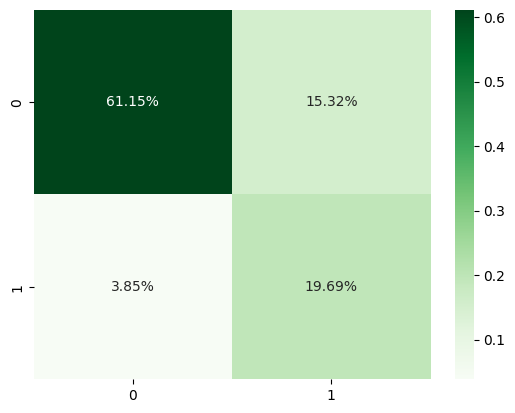

In [ ]:
cm = confusion_matrix(y_test, xgb_pred, labels=xgb.classes_)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
# disp.plot()
# plt.show()
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Greens')
plt.show()

In [ ]:
print(f"Acurácia XGB (Treino): {accuracy_score(y_train, xgb.predict(x_train))}")
print(f"Acurácia XGB (Teste): {accuracy_score(y_test, xgb.predict(x_test))}")
print("====================================")
print(f"Precision XGB (Treino): {precision_score(y_train, xgb.predict(x_train), average='macro')}")
print(f"Precision XGB (Teste): {precision_score(y_test, xgb.predict(x_test), average='macro')}")
print("====================================")
print(f"Recall XGB (Treino): {recall_score(y_train, xgb.predict(x_train), average='macro')}")
print(f"Recall XGB (Teste): {recall_score(y_test, xgb.predict(x_test), average='macro')}")
print("====================================")
print(f"F1-Score XGB (Treino): {f1_score(y_train, xgb.predict(x_train), average='macro')}")
print(f"F1-Score XGB (Teste): {f1_score(y_test, xgb.predict(x_test), average='macro')}")

Acurácia XGB (Treino): 0.8203418959209448
Acurácia XGB (Teste): 0.8083723190959353
Precision XGB (Treino): 0.7646953750048386
Precision XGB (Teste): 0.751651418192912
Recall XGB (Treino): 0.8332735120457596
Recall XGB (Teste): 0.818142577812127
F1-Score XGB (Treino): 0.7828914817794235
F1-Score XGB (Teste): 0.7686081501701894


In [ ]:
features_importance = zip(xgb.feature_importances_, x_features)
for importance, feature in sorted(features_importance, reverse=True):
    print("%s: %f%%" % (feature, importance*100))

valor: 33.317906%
dias_cad_verif: 19.775422%
limite_profissionais: 13.140428%
tier_1_MICRO: 10.810388%
pagamento_online: 9.424493%
tier_2_SMALL: 5.308589%
tier_3_MEDIUM: 4.962548%
tier_4_LARGE: 3.260224%
tier_5_ENTERPRISE: 0.000000%
avecpay_id: 0.000000%


### AdaBoost

In [ ]:
abc = AdaBoostClassifier(random_state=42)
abc.fit(x_res, y_res)

AdaBoostClassifier(random_state=42)

#### Avaliação do Modelo ABC

In [ ]:
abc_pred = pd.DataFrame(abc.predict(x_test), columns=['status_churn'])
abc_pred.status_churn.unique()

array([0, 1])

In [ ]:
abc_pred.status_churn.value_counts()

0    20870
1    12048
Name: status_churn, dtype: int64

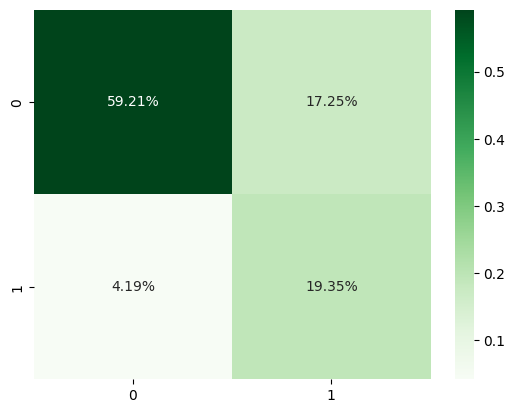

In [ ]:
cm = confusion_matrix(y_test, abc_pred, labels=abc.classes_)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
# disp.plot()
# plt.show()
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Greens')
plt.show()

In [ ]:
print(f"Acurácia ABC (Treino): {accuracy_score(y_train, abc.predict(x_train))}")
print(f"Acurácia ABC (Teste): {accuracy_score(y_test, abc.predict(x_test))}")
print("====================================")
print(f"Precision ABC (Treino): {precision_score(y_train, abc.predict(x_train), average='macro')}")
print(f"Precision ABC (Teste): {precision_score(y_test, abc.predict(x_test), average='macro')}")
print("====================================")
print(f"Recall ABC (Treino): {recall_score(y_train, abc.predict(x_train), average='macro')}")
print(f"Recall ABC (Teste): {recall_score(y_test, abc.predict(x_test), average='macro')}")
print("====================================")
print(f"F1-Score ABC (Treino): {f1_score(y_train, abc.predict(x_train), average='macro')}")
print(f"F1-Score ABC (Teste): {f1_score(y_test, abc.predict(x_test), average='macro')}")

Acurácia ABC (Treino): 0.7889385082088872
Acurácia ABC (Teste): 0.7855884318609879
Precision ABC (Treino): 0.7351050118738673
Precision ABC (Teste): 0.7312798757056107
Recall ABC (Treino): 0.8025071905618141
Recall ABC (Teste): 0.7981964202534793
F1-Score ABC (Treino): 0.7492411762398398
F1-Score ABC (Teste): 0.7450809244739436


In [ ]:
features_importance = zip(abc.feature_importances_, x_features)
for importance, feature in sorted(features_importance, reverse=True):
    print("%s: %f%%" % (feature, importance*100))

valor: 60.000000%
dias_cad_verif: 28.000000%
limite_profissionais: 10.000000%
pagamento_online: 2.000000%
tier_5_ENTERPRISE: 0.000000%
tier_4_LARGE: 0.000000%
tier_3_MEDIUM: 0.000000%
tier_2_SMALL: 0.000000%
tier_1_MICRO: 0.000000%
avecpay_id: 0.000000%


### Gradient Boosting Classifier

In [ ]:
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(x_res, y_res)

GradientBoostingClassifier(random_state=42)

#### Avaliação do Modelo GBC

In [ ]:
gbc_pred = pd.DataFrame(gbc.predict(x_test), columns=['status_churn'])
gbc_pred.status_churn.unique()

array([0, 1])

In [ ]:
gbc_pred.status_churn.value_counts()

0    20936
1    11982
Name: status_churn, dtype: int64

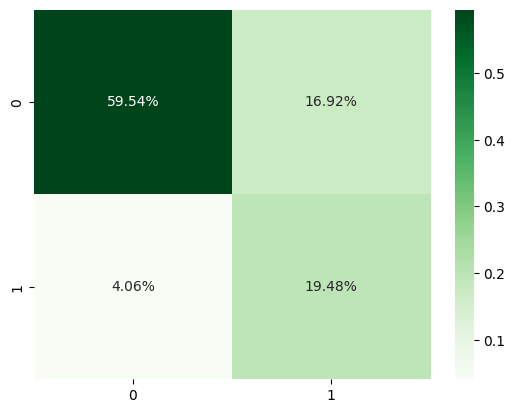

In [ ]:
cm = confusion_matrix(y_test, gbc_pred, labels=gbc.classes_)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
# disp.plot()
# plt.show()
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Greens')
plt.show()

In [ ]:
print(f"Acurácia GBC (Treino): {accuracy_score(y_train, gbc.predict(x_train))}")
print(f"Acurácia GBC (Teste): {accuracy_score(y_test, gbc.predict(x_test))}")
print("====================================")
print(f"Precision GBC (Treino): {precision_score(y_train, gbc.predict(x_train), average='macro')}")
print(f"Precision GBC (Teste): {precision_score(y_test, gbc.predict(x_test), average='macro')}")
print("====================================")
print(f"Recall GBC (Treino): {recall_score(y_train, gbc.predict(x_train), average='macro')}")
print(f"Recall GBC (Teste): {recall_score(y_test, gbc.predict(x_test), average='macro')}")
print("====================================")
print(f"F1-Score GBC (Treino): {f1_score(y_train, gbc.predict(x_train), average='macro')}")
print(f"F1-Score GBC (Teste): {f1_score(y_test, gbc.predict(x_test), average='macro')}")

Acurácia GBC (Treino): 0.7936906792349656
Acurácia GBC (Teste): 0.7902667233732305
Precision GBC (Treino): 0.7397675605329113
Precision GBC (Teste): 0.7357268667936308
Recall GBC (Treino): 0.8079419868706683
Recall GBC (Teste): 0.8032210037311589
F1-Score GBC (Treino): 0.754520812521411
F1-Score GBC (Teste): 0.7501670636268671


In [ ]:
features_importance = zip(gbc.feature_importances_, x_features)
for importance, feature in sorted(features_importance, reverse=True):
    print("%s: %f%%" % (feature, importance*100))

valor: 64.570012%
dias_cad_verif: 29.650546%
limite_profissionais: 5.504065%
tier_1_MICRO: 0.121720%
pagamento_online: 0.090884%
tier_2_SMALL: 0.033481%
tier_3_MEDIUM: 0.017420%
tier_4_LARGE: 0.011872%
tier_5_ENTERPRISE: 0.000000%
avecpay_id: 0.000000%
